# Hackathon Challenge: Predicting Restaurant Annual Turnover

This notebook outlines the process of building a machine learning model to predict the annual turnover of restaurants across India based on various features provided in the dataset.

## Import Necessary Libraries

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from bayes_opt import BayesianOptimization
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor

# Set the aesthetics for plots
sns.set(style='whitegrid')

## Load the Datasets

In [10]:
# Load the training, test, and data dictionary datasets
train_df = pd.read_csv('../data/Train_dataset_(1).csv')
data_dictionary = pd.read_csv('../data/Data_Dictionary_(1).csv')
test_df = pd.read_csv('../data/Test_dataset_(1).csv')
sample_solution_df = pd.read_csv('../data/Sample_Solution_(1).csv')


# Display the first few rows of the train dataset and data dictionary
train_df.head(), data_dictionary

(   Registration Number  Annual Turnover           Cuisine       City  \
 0                60001         42000000      indian,irish  Bangalore   
 1                60002         50000000      indian,irish     Indore   
 2                60003         32500000   tibetan,italian    Chennai   
 3                60004        110000000  turkish,nigerian    Gurgaon   
 4                60005         20000000     irish,belgian    Manesar   
 
   Restaurant Location Opening Day of Restaurant  Facebook Popularity Quotient  \
 0   Near Business Hub                14-02-2009                          84.3   
 1      Near Party Hub                29-09-2008                          85.4   
 2   Near Business Hub                30-07-2011                          85.0   
 3      Near Party Hub                30-11-2008                          85.6   
 4      Near Party Hub                22-02-2010                           NaN   
 
         Endorsed By  Instagram Popularity Quotient  Fire Audit  .

The subsequent cells will include steps for EDA, preprocessing, model training, evaluation, and generating predictions. For now, this structure sets up the initial part of the analysis.

## Distribution of Key Numerical Features

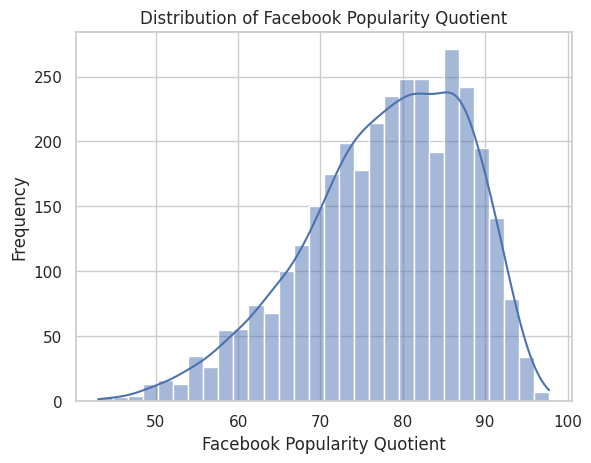

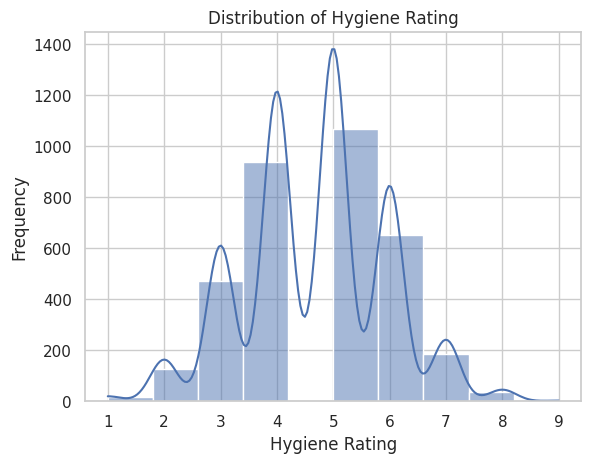

In [11]:
# Distribution of Facebook Popularity Quotient
sns.histplot(train_df['Facebook Popularity Quotient'], bins=30, kde=True)
plt.title('Distribution of Facebook Popularity Quotient')
plt.xlabel('Facebook Popularity Quotient')
plt.ylabel('Frequency')
plt.show()

# Distribution of Hygiene Rating
sns.histplot(train_df['Hygiene Rating'], bins=10, kde=True)
plt.title('Distribution of Hygiene Rating')
plt.xlabel('Hygiene Rating')
plt.ylabel('Frequency')
plt.show()


Analyzing Relationships with the Target Variable

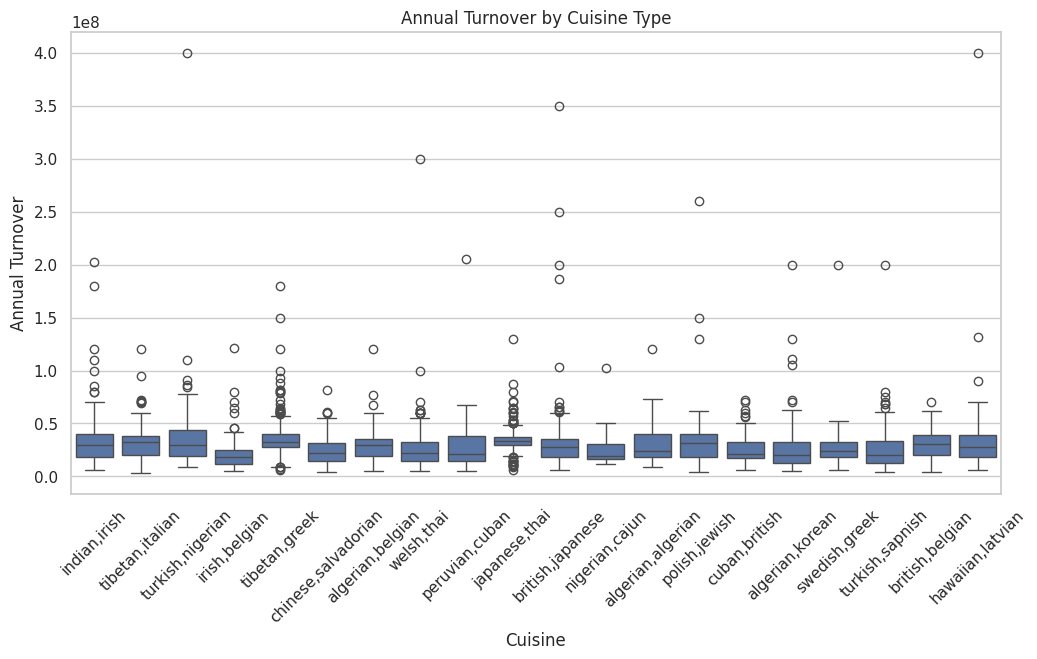

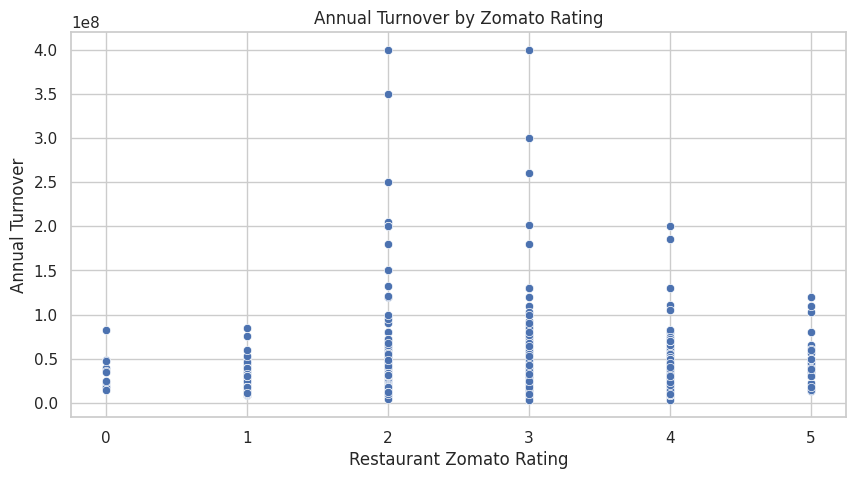

In [12]:
# Relationship between Cuisine and Annual Turnover
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cuisine', y='Annual Turnover', data=train_df)
plt.xticks(rotation=45)
plt.title('Annual Turnover by Cuisine Type')
plt.show()

# Relationship between Restaurant Zomato Rating and Annual Turnover
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Restaurant Zomato Rating', y='Annual Turnover', data=train_df)
plt.title('Annual Turnover by Zomato Rating')
plt.show()


## Correlation Analysis

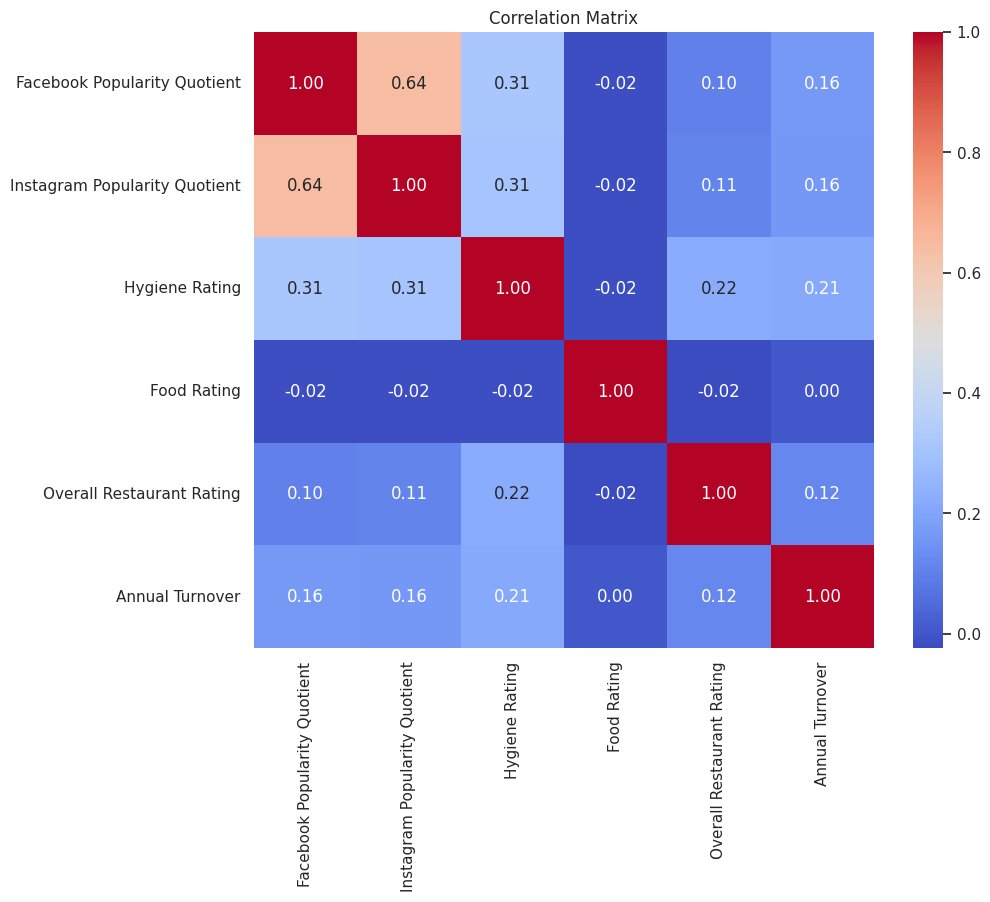

In [13]:
# Correlation matrix for numerical features and Annual Turnover
numerical_features = ['Facebook Popularity Quotient', 'Instagram Popularity Quotient', 
                      'Hygiene Rating', 'Food Rating', 'Overall Restaurant Rating', 
                      'Annual Turnover']
corr_matrix = train_df[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


# Data Processing

## Split the Data

In [14]:
from sklearn.model_selection import train_test_split

X = train_df.drop(['Annual Turnover', 'Registration Number'], axis=1)  # Dropping the target variable and identifier
y = train_df['Annual Turnover']

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


## Model Training

In [15]:
categorical_features = ['Cuisine', 'City', 'Restaurant Location', 'Endorsed By', 'Restaurant Type', 'Restaurant Theme']
numerical_features = ['Facebook Popularity Quotient', 'Instagram Popularity Quotient', 'Restaurant Zomato Rating',
                      'Order Wait Time', 'Staff Responsivness', 'Value for Money', 'Hygiene Rating', 'Food Rating',
                      'Overall Restaurant Rating', 'Live Music Rating', 'Comedy Gigs Rating', 'Value Deals Rating',
                      'Live Sports Rating', 'Ambience', 'Lively', 'Service', 'Comfortablility', 'Privacy']


In [16]:

# Define your evaluation function
def xgb_evaluate(max_depth, gamma, colsample_bytree, min_child_weight, subsample, reg_alpha, n_estimators):
    params = {
        'max_depth': int(max_depth),
        'gamma': gamma,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'min_child_weight': min_child_weight,
        'reg_alpha': reg_alpha,
        'n_estimators': int(n_estimators),
        'learning_rate': 0.1,  # Fixed learning rate
        'objective': 'reg:squarederror'
    }
    
    # Initialize model with current parameters
    xgb_model = xgb.XGBRegressor(**params)
    
    # Pipeline with current model
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('xgb_model', xgb_model)])
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on validation set
    val_pred = model.predict(X_val)
    
    # Calculate RMSE
    rmse = sqrt(mean_squared_error(y_val, val_pred))
    
    # Return the negative RMSE because Bayesian Optimization tries to maximize the function
    return -rmse


In [17]:
# Define the parameter space for Bayesian Optimization
param_space = {
    'max_depth': (3, 10),
    'gamma': (0, 5),
    'colsample_bytree': (0.3, 1.0),
    'min_child_weight': (0, 6),
    'subsample': (0.6, 1.0),
    'reg_alpha': (0, 1.0),
    'n_estimators': (100, 500)  # Adjust the range according to your computational power
}

# Initialize Bayesian optimizer
optimizer = BayesianOptimization(
    f=xgb_evaluate,
    pbounds=param_space,
    random_state=42
)

# Start optimization
optimizer.maximize(init_points=10, n_iter=25)  # Adjust iterations according to your computational power

# Extract the best parameters found by Bayesian Optimization
best_params = optimizer.max['params']

# Cast max_depth and n_estimators to integer since they need to be in integer format
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])


|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | n_esti... | reg_alpha | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | -2.024e+0 | 0.5622    | 4.754     | 8.124     | 3.592     | 162.4     | 0.156     | 0.6232    |
| 2         | -1.969e+0 | 0.9063    | 3.006     | 7.957     | 0.1235    | 488.0     | 0.8324    | 0.6849    |
| 3         | -2.034e+0 | 0.4273    | 0.917     | 5.13      | 3.149     | 272.8     | 0.2912    | 0.8447    |
| 4         | -2.026e+0 | 0.3976    | 1.461     | 5.565     | 2.736     | 414.1     | 0.1997    | 0.8057    |
| 5         | -2.007e+0 | 0.7147    | 0.2323    | 7.253     | 1.023     | 126.0     | 0.9489    | 0.9863    |
| 6         | -1.999e+0 | 0.8659    | 1.523     | 3.684     | 4.105     | 276.1     | 0.122     | 0.7981    |
| 7         | -1.984e+0 | 0.3241    | 4.547     | 4.811     | 3.975     | 224.7     | 0.5201    | 0.8187    |
| 8       

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define base models
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', **best_params, random_state=42)
lgb_model = LGBMRegressor(random_state=42)  # Define with default parameters or pre-tuned parameters

# Define the meta-learner
linear_meta_learner = LinearRegression()

# Define the stacking ensemble
stacking_regressor = StackingRegressor(
    estimators=[
        ('xgb', xgb_model),
        ('lgb', lgb_model)
    ],
    final_estimator=linear_meta_learner,
    cv=5
)

# Create a new pipeline with the stacking ensemble
stacking_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('stacking_regressor', stacking_regressor)
])

# Fit the stacking pipeline
stacking_pipeline.fit(X_train, y_train)

# Predict and calculate RMSE on the validation set
stacking_pred = stacking_pipeline.predict(X_val)
stacking_rmse = sqrt(mean_squared_error(y_val, stacking_pred))
print(f"Stacking RMSE: {stacking_rmse}")




[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 753
[LightGBM] [Info] Number of data points in the train set: 2794, number of used features: 66
[LightGBM] [Info] Start training from score 30716535.433071
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 742
[LightGBM] [Info] Number of data points in the train set: 2235, number of used features: 62
[LightGBM] [Info] Start training from score 30617225.950783
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

In [19]:
from sklearn.model_selection import GridSearchCV

# Define a parameter grid that specifies the parameters of the LightGBM to optimize
# You need to use the name you have given it in the stacking ensemble followed by two underscores
param_grid = {
    'stacking_regressor__lgb__max_depth': [3, 5, 7],
    'stacking_regressor__lgb__learning_rate': [0.01, 0.1, 0.2],
    'stacking_regressor__lgb__n_estimators': [100, 200, 300]
}

# Run grid search with cross-validation on the stacking pipeline
# Make sure to use the stacking_pipeline and not the model variable
grid_search = GridSearchCV(stacking_pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

# Update stacking_pipeline to the best estimator found
stacking_pipeline = grid_search.best_estimator_



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 741
[LightGBM] [Info] Number of data points in the train set: 1862, number of used features: 62
[LightGBM] [Info] Start training from score 30160848.549946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

## Predicition and RMSE Calculation

In [20]:
# Predict the Annual Turnover for the validation set using the optimized stacking pipeline
val_predictions = stacking_pipeline.predict(X_val)
rmse_val = sqrt(mean_squared_error(y_val, val_predictions))
print(f"Validation RMSE with Stacking Ensemble: {rmse_val}")

# If you want to predict the test set, make sure to preprocess it correctly as done with the training set
test_predictions = stacking_pipeline.predict(test_df.drop(['Registration Number'], axis=1, errors='ignore'))

# Prepare the submission dataframe
submission_df = pd.DataFrame({
    'Registration Number': sample_solution_df['Registration Number'],
    'Annual Turnover': test_predictions  # Stacking model's predictions
})

# Save the top 500 predictions to a CSV file
submission_path = '../data/submission_5.csv'
submission_df.to_csv(submission_path, index=False)


Validation RMSE with Stacking Ensemble: 19817410.04277472
